## TODO
- Falta saber cuando va un "_" y cuando un " " adentro del texto
- Falta eliminar caracteres no permitidos en los identificadores

In [ ]:
# !pip install "paddleocr>=2.0.1"
# !python -m pip install paddlepaddle -i https://pypi.tuna.tsinghua.edu.cn/simple

In [9]:
import sys
sys.path.append("../")

from src.line_detection.hough import get_tablas

In [52]:
import re
import os
import jellyfish
import numpy as np

from paddleocr import PaddleOCR
from PIL import Image
from IPython.display import display

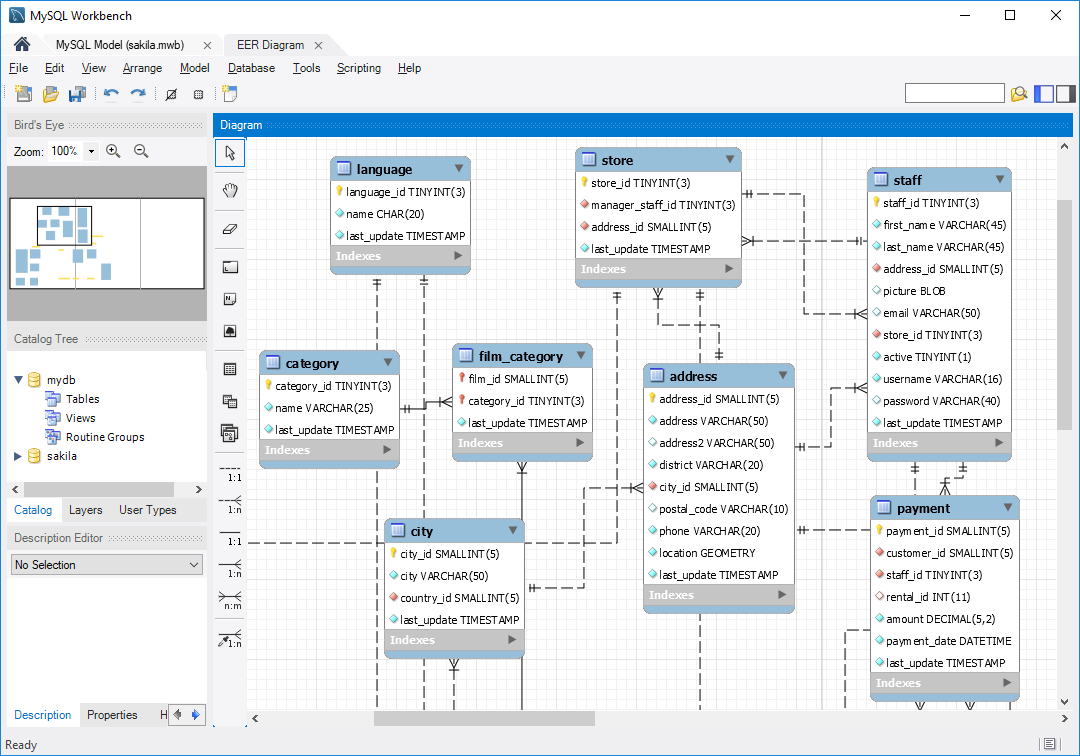

In [45]:
IMG_PATH = '/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-3.png'
IMG_BASENAME = os.path.basename(IMG_PATH)
tablas, cardinalidades = get_tablas(IMG_BASENAME)
img = Image.open(IMG_PATH)
img

In [20]:
ocr = PaddleOCR(use_angle_cls=False, lang='en')

[2023/01/15 16:33:38] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/nacho/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/nacho/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgn

In [55]:
import cv2

In [82]:
def reescale(img, scale_percent=150):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return img

In [83]:
img = Image.open(IMG_PATH)
img = np.array(img)

images = []
results = []

for t in tablas:
    tabla_cropped = img[t[1]:t[3], t[0]:t[2]]
    tabla_cropped = reescale(tabla_cropped)

    result = ocr.ocr(tabla_cropped, cls=False)
    
    images.append(Image.fromarray(tabla_cropped))
    results.append(result[0])

[2023/01/15 19:48:45] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04013848304748535
[2023/01/15 19:48:45] ppocr DEBUG: rec_res num  : 6, elapse : 0.4438455104827881
[2023/01/15 19:48:45] ppocr DEBUG: dt_boxes num : 7, elapse : 0.044495582580566406
[2023/01/15 19:48:46] ppocr DEBUG: rec_res num  : 7, elapse : 0.5992519855499268
[2023/01/15 19:48:46] ppocr DEBUG: dt_boxes num : 13, elapse : 0.07978177070617676
[2023/01/15 19:48:47] ppocr DEBUG: rec_res num  : 13, elapse : 1.0342037677764893
[2023/01/15 19:48:47] ppocr DEBUG: dt_boxes num : 10, elapse : 0.05347037315368652
[2023/01/15 19:48:48] ppocr DEBUG: rec_res num  : 10, elapse : 0.9505977630615234
[2023/01/15 19:48:48] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03747868537902832
[2023/01/15 19:48:49] ppocr DEBUG: rec_res num  : 5, elapse : 0.43199992179870605
[2023/01/15 19:48:49] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03456568717956543
[2023/01/15 19:48:49] ppocr DEBUG: rec_res num  : 5, elapse : 0.4014110565185547
[2023/01/15 19:4

In [157]:
def get_allowed_dtypes(db_name):
    if db_name.lower() == "mysql":
        STRING_TYPES = ["CHAR", "VARCHAR", "BINARY", "VARBINARY", "TINYBLOB", "TINYTEXT", "TEXT", "BLOB", 
                        "MEDIUMTEXT", "MEDIUMBLOB", "LONGTEXT", "LONGBLOB", "ENUM", "SET"]
        NUMERIC_TYPES = ["BIT", "TINYINT", "BOOLEAN", "SMALLINT", "MEDIUMINT", "INT", "INTEGER", "BIGINT", 
                         "FLOAT", "DOUBLE", "DOUBLE PRECISION", "DECIMAL", "DEC"]
        DATETIME_TYPES = ["DATE", "DATETIME", "TIMESTAMP", "TIME", "YEAR"]
        SPATIAL_TYPES = ["GEOMETRY", "POINT", "LINESTRING", "POLYGON"]
        return (STRING_TYPES + NUMERIC_TYPES + DATETIME_TYPES + SPATIAL_TYPES)
    else:
        print(f"'{db_name}' not supported yet!")
        return []

In [158]:
def get_dtype_number(text):
    if "," not in text:
        return re.findall("\d+", text) # Devuelve solo numeros juntos.
    else:
        return re.findall("\d+\,\d+", text) # Devuelve numeros con coma para dtypes como DECIMAL(5,2)

In [159]:
def sep_text(text):
    return re.findall("[A-Z]+[^A-Z]*|[^A-Z]+",text)

In [160]:
def get_dtype(possible_dtype, dtypes):
    dict_dtypes = {k: jellyfish.jaro_distance(possible_dtype, k) for k in dtypes}
    return (max(dict_dtypes, key=dict_dtypes.get), max(dict_dtypes.values()))

In [161]:
def separate(text, db_name="mysql"):
    text_list = sep_text(text)
    flag = False
    attribute = ""
    i = 0
    while not flag:
        if text_list[i].islower():
            attribute += text_list[i]
            i += 1
        else:
            flag = True
    dtype = "".join(text_list[i:])
    dtype_number = get_dtype_number(dtype)
    dtype = dtype.replace("(", "").replace(")","")
    dtype, _ = get_dtype(dtype, dtypes=get_allowed_dtypes(db_name))
    if dtype_number:
        dtype += f"({dtype_number[0]})"
        
    return attribute, dtype

In [165]:
def clean_texts(texts):
    if "Indexes" in texts:
        texts.remove("Indexes")
        
    table_name = texts[0]
    
    attributes = {} # K=name, V=type
    for t in texts[1:]:
        attribute, dtype = separate(t, db_name="mysql")
        attributes[attribute.strip()] = dtype
            
    return table_name, attributes

In [166]:
clean_texts(txts)

('address',
 {'address_id': 'SMALLINT(5)',
  'address': 'VARCHAR(50)',
  'address2': 'VARCHAR(50)',
  'district': 'VARCHAR(20)',
  'city_id': 'SMALLINT(5)',
  'postal_code': 'VARCHAR(10)',
  'phone': 'VARCHAR(20)',
  'location': 'GEOMETRY',
  'last_update': 'TIMESTAMP'})

('language', {'language_id': 'TINYINT(3)', 'name': 'CHAR(20)', 'last_update': 'TIMESTAMP'})


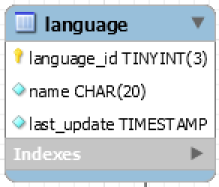

('store', {'store_id': 'TINYINT(3)', 'm anager_staff_id': 'TINYINT(3)', 'address_id': 'SMALLINT(5)', 'last_update': 'TIMESTAMP'})


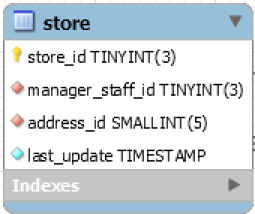

('staff', {'staff id': 'TINYINT(3)', 'first_nam e': 'VARCHAR(45)', '|ast_name': 'VARCHAR(45)', 'address_id': 'SMALLINT(5)', 'picture': 'BLOB', 'email': 'VARCHAR(50)', 'store_id': 'TINYINT(3)', 'active': 'TINYINT(1)', 'username': 'VARCHAR(16)', 'password': 'VARCHAR(40)', 'last_update': 'TIMESTAMP'})


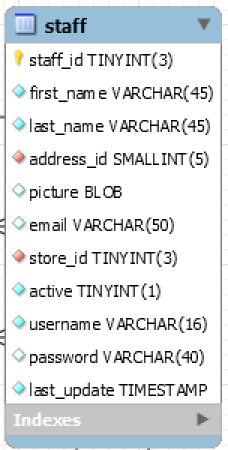

('payment', {'paym ent_id': 'SMALLINT(5)', 'customer_id': 'SMALLINT(5)', 'staff_id': 'TINYINT(3)', 'rental_id': 'INT(11)', 'amount': 'DECIMAL(5,2)', 'paym ent_date': 'DATETIME', 'last_update': 'TIMESTAMP'})


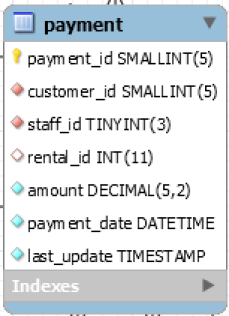

('category', {'category_id': 'TINYINT(3)', 'name': 'VARCHAR(25)', 'last_update': 'TIMESTAMP'})


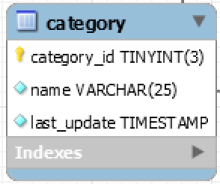

('film_category', {'film_id': 'SMALLINT(5)', 'category_id': 'TINYINT(3)', 'last_update': 'TIMESTAMP'})


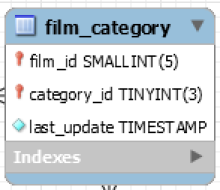

('city', {'? city_id': 'SMALLINT(5)', 'ci ty': 'VARCHAR(50)', 'country_id': 'SMALLINT(5)', 'last_update': 'TIMESTAMP'})


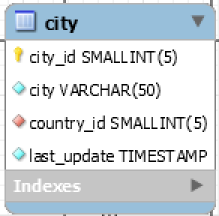

('address', {'address_id': 'SMALLINT(5)', 'address': 'VARCHAR(50)', 'address2': 'VARCHAR(50)', 'district': 'VARCHAR(20)', 'city_id': 'SMALLINT(5)', 'postal_code': 'VARCHAR(10)', 'phone': 'VARCHAR(20)', 'location': 'GEOMETRY', 'last_update': 'TIMESTAMP'})


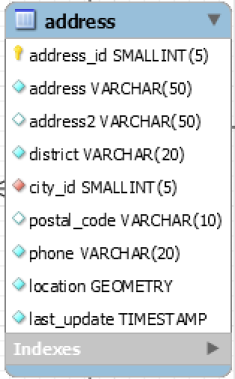

In [167]:
for i, r in zip(images, results):
    boxes = [line[0] for line in r]
    txts = [line[1][0].strip() for line in r]
    scores = [line[1][1] for line in r]
        
    print(clean_texts(txts))
    display(i)

In [ ]:
def sep_text(text):
    return re.findall("[A-Z]+[^A-Z]*|[^A-Z]+",text)


def get_dtype(possible_dtype, dtypes):
    dict_dtypes = {k: jellyfish.jaro_distance(possible_dtype, k) for k in dtypes}
    return (max(dict_dtypes, key=dict_dtypes.get), max(dict_dtypes.values()))


def separate(text):
    text_list = sep_text(text)
    flag = False
    attribute = ""
    i = 0
    while not flag:
        if text_list[i].islower():
            attribute += text_list[i]
            i += 1
        else:
            flag = True
    dtype = "".join(text_list[i:])
    dtype, _ = get_dtype(dtype, dtypes=get_allowed_dtypes("mysql"))
    return attribute, dtype